In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/week8data/ans.csv
/kaggle/input/week8data/train.csv
/kaggle/input/week8data/test.csv


In [151]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


* train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。
* test.csv 的資料為剩下日子裡資料
* 本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測第 10 個小時的 PM2.5。


In [311]:
data = pd.read_csv('../input/week8data/train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()
raw_data.shape

(4320, 24)

In [312]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

In [313]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x.shape,y.shape)

(5652, 162) (5652, 1)


# normalized

In [243]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

In [314]:
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float) # error turn
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(4521, 163) (1131, 163) (4521, 1) (1131, 1)


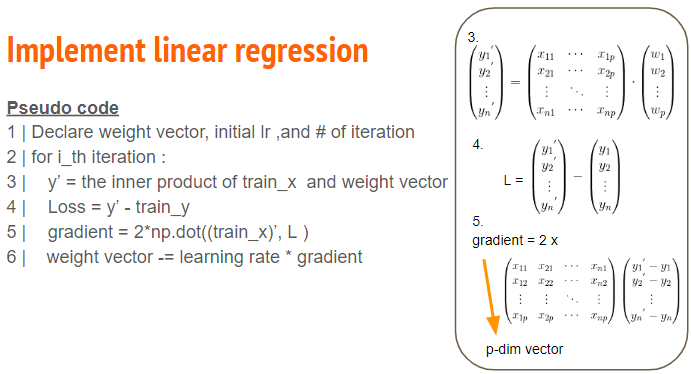

# SGD

In [293]:
loss_array_train = []
loss_array_test = []
iter_array = []
learning_rate = 0.0000000002
w = np.zeros([18*9+1,1])

for i in range(200001):
    loss = np.sqrt(np.sum((x_train@w - y_train)**2)/x_train.shape[0]) # rmse
    loss_vali = np.sqrt(np.sum((x_test @ w - y_test)**2)/x_test.shape[0])   #validation
    if i%10000 ==0:
        print('iteration:{}   loss:{}   vali:{}'.format(i,loss,loss_vali))
    gradient = 2 * np.dot(x_train.T,x_train @ w - y_train)
    w= w - learning_rate * gradient
   
    loss_array_train.append(loss)
    loss_array_test.append(loss_vali)
    iter_array.append(i)

iteration:0   loss:27.012465684693296   vali:27.30479306162072
iteration:10000   loss:6.513367014571586   vali:6.777439389172256
iteration:20000   loss:6.141617697990314   vali:6.430834125872472
iteration:30000   loss:5.994731606677213   vali:6.288369554643581
iteration:40000   loss:5.915504447535969   vali:6.204535865479456
iteration:50000   loss:5.86542525721253   vali:6.146649920691639
iteration:60000   loss:5.830767070031631   vali:6.103447499962615
iteration:70000   loss:5.805456211217164   vali:6.069814654798996
iteration:80000   loss:5.786355939325332   vali:6.042962649527044
iteration:90000   loss:5.77163603353556   vali:6.02116757471255
iteration:100000   loss:5.760124949050238   vali:6.003268777553049
iteration:110000   loss:5.751022240887863   vali:5.988438922185568
iteration:120000   loss:5.743756558283452   vali:5.976065147314993
iteration:130000   loss:5.737908038309453   vali:5.965681082848533
iteration:140000   loss:5.733161996553549   vali:5.956924718823507
iteration:1

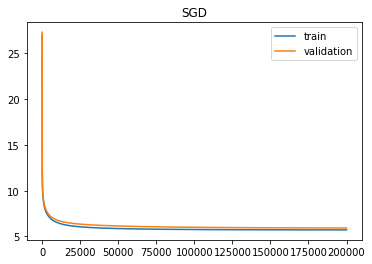

In [294]:
plt.plot(iter_array,loss_array_train,label="train")
plt.plot(iter_array,loss_array_test,label="validation")
plt.title("SGD")
plt.legend()


# Adagrad

In [358]:
loss_array_train = []
loss_array_test = []
iter_array = []
learning_rate = 100
adagrad = np.zeros([18*9+1, 1])
w = np.zeros([18*9+1, 1])

for i in range(100001):
    loss = np.sqrt(np.sum((x_train@w - y_train)**2)/x_train.shape[0])
    loss_vali = np.sqrt(np.sum((x_test @ w - y_test)**2)/x_test.shape[0])
    if i%1000 ==0:
        print('iteration:{}   loss:{}   vali:{}'.format(i,loss,loss_vali))
    gradient = 2 * np.dot(x_train.T,x_train @ w - y_train)
    adagrad += gradient**2
    w= w - learning_rate * gradient / np.sqrt(adagrad+1e-10)
    loss_array_train.append(loss)
    loss_array_test.append(loss_vali)
    iter_array.append(i)

iteration:0   loss:27.012465684693296   vali:27.30479306162072
iteration:1000   loss:7.020134608450497   vali:7.31195078953902
iteration:2000   loss:6.498317742082639   vali:6.789463175745659
iteration:3000   loss:6.2604536920695   vali:6.557300352743317
iteration:4000   loss:6.124077902190412   vali:6.425293313267514
iteration:5000   loss:6.035514914211891   vali:6.339005186494321
iteration:6000   loss:5.973313586467597   vali:6.277132158829882
iteration:7000   loss:5.9272068619496485   vali:6.229858563822372
iteration:8000   loss:5.891650101498516   vali:6.192108549667271
iteration:9000   loss:5.863383338661915   vali:6.1610039608966005
iteration:10000   loss:5.8403667844956955   vali:6.134784183242351
iteration:11000   loss:5.821262171946394   vali:6.112303300660564
iteration:12000   loss:5.80515752402204   vali:6.0927768912194855
iteration:13000   loss:5.791411073803697   vali:6.0756453087945435
iteration:14000   loss:5.77955815894069   vali:6.060495243915163
iteration:15000   loss

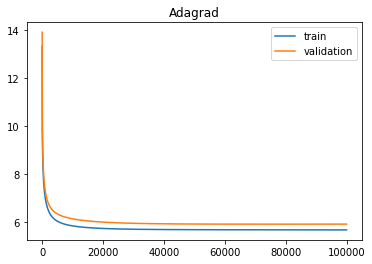

In [320]:
plt.plot(iter_array[10:],loss_array_train[10:],label="train")
plt.plot(iter_array[10:],loss_array_test[10:],label="validation")
plt.title("Adagrad")
plt.legend()


In [321]:
test_data = pd.read_csv('../input/week8data/test.csv',encoding = 'big5',header = None)
test_data.replace('NR',0,inplace=True)
test_data = test_data.iloc[:,2:]
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
    
'''
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
'''

test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

array([[ 1. , 15. , 14. , ...,  2.5,  2.5,  2.3],
       [ 1. , 12. , 12. , ...,  2.1,  2.6,  1.5],
       [ 1. ,  8.8, 12. , ...,  2.6,  1.8,  1.4],
       ...,
       [ 1. , 12. , 11. , ...,  1.8,  1.6,  0.6],
       [ 1. , 14. , 13. , ...,  1.6,  2.1,  1.8],
       [ 1. , 11. , 11. , ...,  0.6,  0.5,  0.5]])

In [352]:
ans = pd.read_csv('../input/week8data/ans.csv',encoding = 'big5')
ans = ans['value'].to_numpy()
ans_y = ans_y.reshape(240,)
ans_rmse = np.sqrt(np.sum((ans_y-ans)**2)/ans.shape[0])
print('test root mean square: {}'.format(ans_rmse))

test root mean square: 6.539317285043963


> ***Adagrand 可以比SGD更快收斂***

# normalized v.s. raw

In [353]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x.shape,y.shape)

mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float) # error turn
xn_train,xn_test,yn_train,yn_test = train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(5652, 162) (5652, 1)
(4521, 163) (1131, 163) (4521, 1) (1131, 1)


In [363]:
loss_array_train_n = []
loss_array_test_n = []
iter_array = []
learning_rate = 100
adagrad = np.zeros([18*9+1, 1])
w = np.zeros([18*9+1, 1])

for i in range(100001):
    loss = np.sqrt(np.sum((xn_train@w - yn_train)**2)/xn_train.shape[0])
    loss_vali = np.sqrt(np.sum((xn_test @ w - yn_test)**2)/xn_test.shape[0])
    if i%1000 ==0:
        print('iteration:{}   loss:{}   vali:{}'.format(i,loss,loss_vali))
    gradient = 2 * np.dot(xn_train.T,xn_train @ w - yn_train)
    adagrad += gradient**2
    w= w - learning_rate * gradient / np.sqrt(adagrad+1e-10)
    loss_array_train_n.append(loss)
    loss_array_test_n.append(loss_vali)
    iter_array.append(i)

iteration:0   loss:27.012465684693296   vali:27.30479306162072
iteration:1000   loss:7.270725838000157   vali:7.71333873153638
iteration:2000   loss:6.0772809385660125   vali:6.504285100409294
iteration:3000   loss:5.786124117476486   vali:6.179003721810314
iteration:4000   loss:5.696528062868086   vali:6.063370693098883
iteration:5000   loss:5.665275345377787   vali:6.016084104786829
iteration:6000   loss:5.653422283278889   vali:5.995067194053589
iteration:7000   loss:5.648572408714323   vali:5.985236630025124
iteration:8000   loss:5.646408949318448   vali:5.980536810493557
iteration:9000   loss:5.645334109229386   vali:5.978314077837479
iteration:10000   loss:5.644726127316519   vali:5.977323159377833
iteration:11000   loss:5.644331540978473   vali:5.976950136334535
iteration:12000   loss:5.644042163821336   vali:5.97688280144288
iteration:13000   loss:5.643809592560243   vali:5.976960083660041
iteration:14000   loss:5.643611066880326   vali:5.9770990145384255
iteration:15000   loss

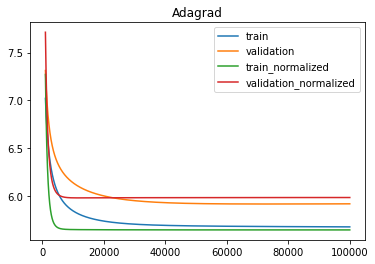

In [366]:
plt.plot(iter_array[1000:],loss_array_train[1000:],label="train")
plt.plot(iter_array[1000:],loss_array_test[1000:],label="validation")
plt.plot(iter_array[1000:],loss_array_train_n[1000:],label="train_normalized")
plt.plot(iter_array[1000:],loss_array_test_n[1000:],label="validation_normalized")
plt.title("Adagrad")
plt.legend()


> Normalized 會更早收斂